<a href="https://colab.research.google.com/github/MachineAbiogenesis/MachineLearning/blob/main/ASL_ALPHABATE_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

! pip install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

! kaggle datasets download -d grassknoted/asl-alphabet

!rm -rf '/content/train/'
!mkdir train


!unzip /content/asl-alphabet.zip -d train





In [ ]:
from glob import glob
import random
import os

IMG_SIZE=100 

def make_dataset(path, batch_size):

  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg (image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image

  def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

  classes = os.listdir(path)
  filenames = glob(path + '/*/*')
  random.shuffle(filenames)
  labels = [classes.index(name.split('/')[-2]) for name in filenames]
  revlab = dict(list(enumerate(classes)))

  filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
  print(len(filenames_ds))
  images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  labels_ds = tf.data.Dataset.from_tensor_slices(labels)
  ds = tf.data.Dataset.zip((images_ds, labels_ds))
  ds = configure_for_performance(ds)

  return ds

In [ ]:
# path3='/content/train/test/'

# dataset_test=make_dataset(path3,64)

# path2='/content/train/asl_alphabet_test/asl_alphabet_test/'

# dataset_valid=make_dataset(path2,64)


path='/content/train/asl_alphabet_train/asl_alphabet_train/'

dataset_new=make_dataset(path,128)

dataset_valid=dataset_new.take(100)
dataset_new=dataset_new.skip(100)

# for image, label in dataset_new.take(1):
#     print(image.numpy())
#     print(label.numpy())

87000


In [ ]:
import tensorflow as tf

asl_model6=tf.keras.models.Sequential([
                                      tf.keras.layers.Rescaling(1./255),
                                      tf.keras.layers.RandomRotation(0.2),
                                      tf.keras.layers.RandomFlip(mode='horizontal'),
                                      tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(100, 100, 3)),
                                      tf.keras.layers.Dropout(0.2),
                                      tf.keras.layers.MaxPool2D(2,2),
                                      tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
                                      tf.keras.layers.Dropout(0.2),
                                      tf.keras.layers.MaxPool2D(2,2),
                                      tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
                                      tf.keras.layers.Dropout(0.2),
                                      tf.keras.layers.MaxPool2D(2,2),
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dense(128,activation='relu'),
                                      tf.keras.layers.Dropout(0.2),
                                      tf.keras.layers.Dense(29,activation='softmax')

])

asl_model6.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

asl_model6.build((None,100, 100, 3))


In [ ]:

asl_model6.summary()
# # test_dataset = dataset_new.take(100) 
# # train_dataset = dataset_new.skip(100)


class MyCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epochs, logs=None):
    if(logs.get("accuracy")>0.9):
      self.model.stop_training = True


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 100, 100, 3)      0         
 tion)                                                           
                                                                 
 random_flip (RandomFlip)    (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 dropout (Dropout)           (None, 98, 98, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                      

In [ ]:
dataset_new.take(1)

<TakeDataset shapes: ((None, 100, 100, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:

history5=asl_model6.fit(
    dataset_new,
    validation_data=dataset_valid,
    steps_per_epoch=579,
    epochs=15,
    validation_steps=100,
)

Epoch 1/15
579/579 [==============================] - 55s 69ms/step - loss: 2.5905 - accuracy: 0.2207 - val_loss: 1.9070 - val_accuracy: 0.4687
Epoch 2/15
579/579 [==============================] - 37s 63ms/step - loss: 1.6358 - accuracy: 0.4623 - val_loss: 1.3597 - val_accuracy: 0.5948
Epoch 3/15
579/579 [==============================] - 36s 63ms/step - loss: 1.2438 - accuracy: 0.5757 - val_loss: 0.9875 - val_accuracy: 0.7304
Epoch 4/15
579/579 [==============================] - 37s 64ms/step - loss: 1.0271 - accuracy: 0.6428 - val_loss: 0.9320 - val_accuracy: 0.7270
Epoch 5/15
579/579 [==============================] - 38s 65ms/step - loss: 0.8758 - accuracy: 0.6919 - val_loss: 0.7161 - val_accuracy: 0.8170
Epoch 6/15
579/579 [==============================] - 39s 67ms/step - loss: 0.7567 - accuracy: 0.7312 - val_loss: 0.5847 - val_accuracy: 0.8649
Epoch 7/15
579/579 [==============================] - 40s 69ms/step - loss: 0.6764 - accuracy: 0.7607 - val_loss: 0.5113 - val_accuracy:

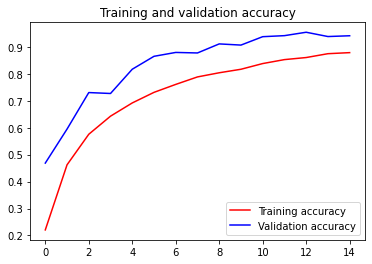

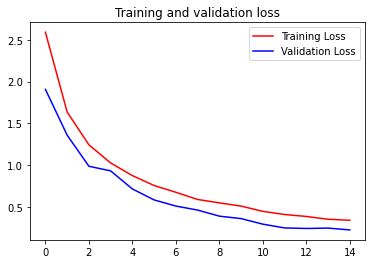

In [ ]:
import matplotlib.pyplot as plt
acc = history5.history['accuracy'] ### YOUR CODE HERE
val_acc = history5.history['val_accuracy'] ### YOUR CODE HERE
loss = history5.history['loss'] ### YOUR CODE HERE
val_loss = history5.history['val_loss'] ### YOUR CODE HERE

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
asl_model3.evaluate(dataset_test,steps=24)

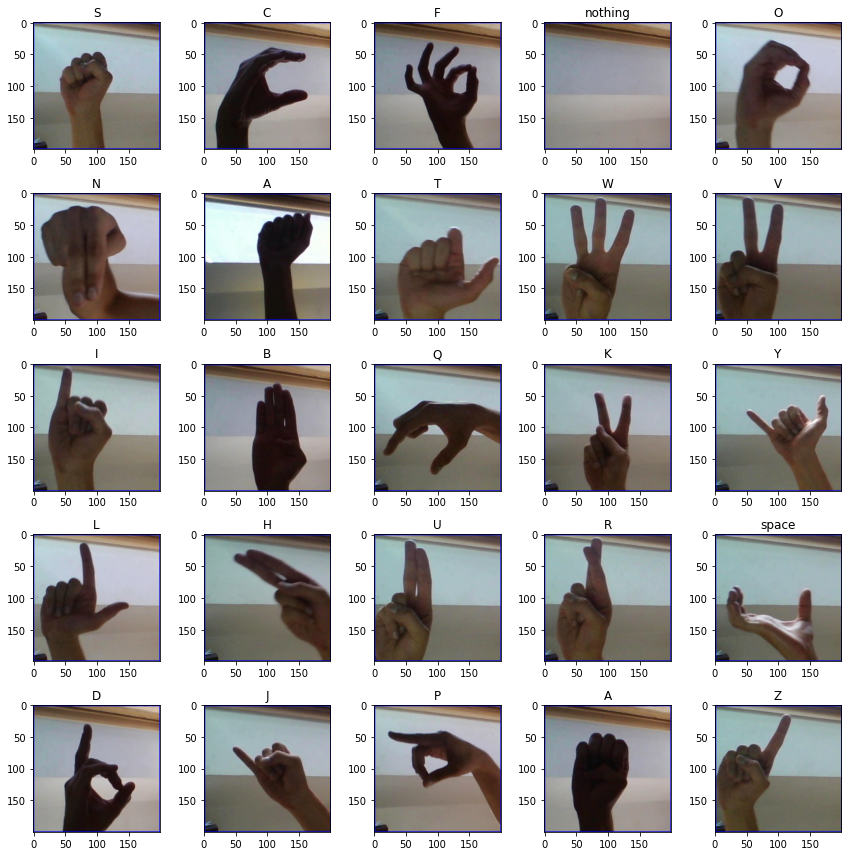

In [ ]:

import numpy as np
from keras.preprocessing import image
import os
import matplotlib.pyplot as plt
pathtest='/content/train/asl_alphabet_test/asl_alphabet_test/'
imagess = os.listdir(pathtest)

ans=[]
for index,i in enumerate(imagess):
    if i =='.ipynb_checkpoints':
      continue
    print()
    # predicting images
    path = pathtest + i
    img = image.load_img(path, target_size=(100 , 100 ))
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    images = np.vstack([x])
    classes = asl_model6.predict(images, batch_size=10)
    ans.append(np.argmax(classes))

classes = os.listdir('/content/train/asl_alphabet_train/asl_alphabet_train/')
labels_map=dict(list(enumerate(classes)))



fig,axes=plt.subplots(nrows=5,ncols=5,figsize=(12,12))

for i,ax in enumerate(axes.flat):
  x=plt.imread(pathtest+imagess[i])#reading the image
  ax.imshow(x)
  ax.set_title(str(labels_map.get(ans[i])))
plt.tight_layout()    
plt.show()   
    

In [ ]:
# asl_model.save("asl_SignLanguage")

In [ ]:
asl_model.save("asl_SignLanguage2.h5")